This notebook will explain how to retrieve `IceNet` data from the public API and display it locally.

The forecasts are made on the central part (432x432) of the 720x720 [EASE2 5km grid](https://nsidc.org/ease/ease-grid-projection-gt) projections.
This means that the northern hemisphere uses the [EPSG:6931](https://epsg.io/6931) projection and the southern hemisphere uses [EPSG:6932](https://epsg.io/6932).

In [1]:
# Import required modules
import datetime
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Set the base URL for API requests
api_base_url = "https://app-icenetgeoapi-pygeoapi.azurewebsites.net/"

In [3]:
# Find out which collections are available
response = requests.get(f"{api_base_url}/collections")
collections = response.json()["collections"]
for c in collections:
    print(f"{c['id']}; {c['title']}; {c['description']}")

north_cells; Northern hemisphere geometric grid cells; Northern hemisphere geometric grid cells
south_cells; Southern hemisphere geometric grid cells; Southern hemisphere geometric grid cells
north_forecasts; Northern hemisphere sea ice concentration forecasts; Northern hemisphere sea ice concentration forecasts
south_forecasts; Southern hemisphere sea ice concentration forecasts; Southern hemisphere sea ice concentration forecasts


We can see that there are currently four collections available
- Northern hemisphere cells (details of the geometries of the grid)
- Northern hemisphere forecasts (forecasted sea ice concentration from the IceNet algorithm)
- Southern hemisphere cells (details of the geometries of the grid)
- Southern hemisphere forecasts (forecasted sea ice concentration from the IceNet algorithm)

In [4]:
# Find the list of queryables for northern hemisphere forecasts
response = requests.get(f"{api_base_url}/collections/north_forecasts/queryables") 
response.json()

{'type': 'object',
 'title': 'Northern hemisphere sea ice concentration forecasts',
 'properties': {'geometry': {'$ref': 'https://geojson.org/schema/Geometry.json'},
  'forecast_latest_id': {'title': 'forecast_latest_id', 'type': 'int8'},
  'date_forecast_generated': {'title': 'date_forecast_generated',
   'type': 'date'},
  'date_forecast_for': {'title': 'date_forecast_for', 'type': 'date'},
  'sea_ice_concentration_mean': {'title': 'sea_ice_concentration_mean',
   'type': 'float4'},
  'sea_ice_concentration_stddev': {'title': 'sea_ice_concentration_stddev',
   'type': 'float4'}},
 '$schema': 'http://json-schema.org/draft/2019-09/schema',
 '$id': 'https://app-icenetgeoapi-pygeoapi.azurewebsites.net/collections/north_forecasts/queryables'}

and here we can see the available, query-able columns
- `date_forecast_generated` (the date when the forecast was made)
- `date_forecast_for` (which date the forecast was made for)
- `sea_ice_concentration_mean` (the mean of the IceNet forecast)
- `sea_ice_concentration_stddev` (the standard deviation of the IceNet forecast)

In [5]:
# Get the latest available forecasts (limited to first 10 by default)
response = requests.get(f"{api_base_url}/collections/north_forecasts/items") 

In [6]:
# Take a look at the available features
response.json()["features"]

[{'type': 'Feature',
  'geometry': {'type': 'Polygon',
   'coordinates': [[[45, 16.8228850033408],
     [45.132936604874, 16.623695732259],
     [45, 16.4247079225175],
     [44.867063395126, 16.623695732259],
     [45, 16.8228850033408]]]},
  'properties': {'forecast_latest_id': 1,
   'date_forecast_generated': '2022-02-12',
   'date_forecast_for': '2022-02-13',
   'sea_ice_concentration_mean': 0.0352753,
   'sea_ice_concentration_stddev': 0.0705506},
  'id': 1},
 {'type': 'Feature',
  'geometry': {'type': 'Polygon',
   'coordinates': [[[44.7322646612978, 17.2190997847523],
     [44.8664436462941, 17.0213529826143],
     [44.7335099239416, 16.8219602213448],
     [44.5993367442078, 17.0195015207504],
     [44.7322646612978, 17.2190997847523]]]},
  'properties': {'forecast_latest_id': 2,
   'date_forecast_generated': '2022-02-12',
   'date_forecast_for': '2022-02-13',
   'sea_ice_concentration_mean': 0.0517279,
   'sea_ice_concentration_stddev': 0.103456},
  'id': 2},
 {'type': 'Featur

We can look at forecasts made on a particular date for a particular date in the future: we'll choose two weeks from today.

In [7]:
# Set the target
target_date = (datetime.datetime.today() + datetime.timedelta(days=14)).date()

Let's look at the latest available set of forecasts (probably made today or yesterday) for this date

In [8]:
# As Azure has a hard-coded 230s timeout we must retrieve the results in batches
batch_size = 50000
n_data_points = batch_size
start_index = 0

# In order to retrieve all the results we keep making requests until the API stops returning new data
responses = []
while n_data_points == batch_size:
    response = requests.get(f"{api_base_url}/collections/north_forecasts/items?date_forecast_for={target_date}&startindex={start_index}&limit={batch_size}")
    n_data_points = len(response.json()['features'])
    responses.append(response)
    start_index += batch_size
    print(f"Loaded batch of {n_data_points} forecasts...")
print(f"Finished: loaded {sum([len(r.json()['features']) for r in responses])} forecasts in total")

Loaded batch of 50000 forecasts...
Loaded batch of 39097 forecasts...
Finished: loaded 89097 forecasts in total


We have now retrieved data for all grid cells that have a non-zero forecast for sea-ice coverage.

Rather than looking at the JSON directly, it is probably better to deal with a library that understands GeoJSON.
In the rest of this example, we will use `geopandas`.

In [9]:
# Look at the first few rows of data
geodata = pd.concat([gpd.GeoDataFrame.from_features(r.json(), crs="EPSG:4326") for r in responses])
geodata.head()

,geometry,forecast_latest_id,date_forecast_generated,date_forecast_for,sea_ice_concentration_mean,sea_ice_concentration_stddev
0,"POLYGON ((-117.40758 33.08863, -117.51637 33.3...",1336456,2022-02-12,2022-02-28,5.966070e-07,6.956920e-07
1,"POLYGON ((-117.19813 33.20618, -117.30636 33.4...",1336457,2022-02-12,2022-02-28,8.117340e-07,9.469560e-07
2,"POLYGON ((-116.98789 33.32282, -117.09555 33.5...",1336458,2022-02-12,2022-02-28,8.662310e-07,1.076740e-06
3,"POLYGON ((-116.56505 33.55339, -116.67155 33.7...",1336459,2022-02-12,2022-02-28,9.807390e-07,1.342920e-06
4,"POLYGON ((-116.35245 33.66731, -116.45836 33.8...",1336460,2022-02-12,2022-02-28,9.987940e-07,1.297210e-06


Let's drop the forecast ID (this is internal database bookkeeping).
We also convert from EPSG:4326 (World Geodetic System projection) to EPSG:6931 (NSIDC EASE-Grid for the North Pole)

In [10]:
geodata.drop(["forecast_latest_id"], axis=1, inplace=True)
geodata.to_crs(6931, inplace=True)
geodata.head()

,geometry,date_forecast_generated,date_forecast_for,sea_ice_concentration_mean,sea_ice_concentration_stddev
0,"POLYGON ((-5400000.001 2800000.000, -5375000.0...",2022-02-12,2022-02-28,5.966070e-07,6.956920e-07
1,"POLYGON ((-5400000.001 2775000.000, -5375000.0...",2022-02-12,2022-02-28,8.117340e-07,9.469560e-07
2,"POLYGON ((-5400000.001 2750000.000, -5375000.0...",2022-02-12,2022-02-28,8.662310e-07,1.076740e-06
3,"POLYGON ((-5400000.001 2700000.000, -5375000.0...",2022-02-12,2022-02-28,9.807390e-07,1.342920e-06
4,"POLYGON ((-5400000.001 2675000.000, -5375000.0...",2022-02-12,2022-02-28,9.987940e-07,1.297210e-06


In [11]:
# Load geometries for all world landmasses (except Antarctica)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.loc[world.continent != 'Antarctica']

In [12]:
# Define a boundary at a 6000km radius from the North Pole
from shapely.geometry import Point
boundary = gpd.GeoDataFrame({"origin": [Point(0, 0)], "geometry": [Point(0, 0).buffer(6000 * 1000)]}, crs="EPSG:6931")

In [13]:
# Intersect landmasses with the boundary
world_np = gpd.overlay(world.to_crs("EPSG:6931"), boundary, how='intersection')

<AxesSubplot:>

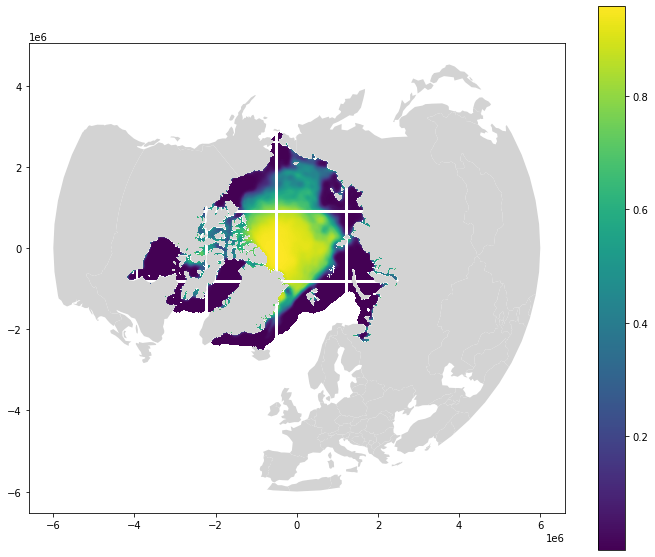

In [14]:
# Plot points on a world map
fig, ax = plt.subplots(1, figsize=(12,10))
world_np.plot(ax=ax, color="lightgray")
geodata.plot(ax=ax, column='sea_ice_concentration_mean', markersize=0.1, legend=True)

You have now succesfully retrieved `IceNet` data from our API and plotted it on a world map. 🎉